In [1]:
import laspy 
import numpy as np
import os
import re
import math
import pyvista as pv
from geometric_attributes import *
from utils import *

# folder_path = r"C:\Users\telukkari\Documents\Python\forest_road_bearing_capacity\data\deep_learning_preds\lieksa_preds"
folder_path = r"C:\Users\telukkari\Documents\Python\forest_road_bearing_capacity\data\deep_learning_preds\lieksa_preds\kiimasuo"

pattern = re.compile(r"avg_predictions_segment_(\d+)\.las$")

# for subfolder in os.listdir(folder_path):
files = []

for fname in os.listdir(folder_path):
    match = pattern.search(fname)
    if match:
        num = int(match.group(1))
        files.append((num, fname))

files_sorted = [fname for num, fname in sorted(files, key=lambda x: x[0])]

positions = []

for filename in files_sorted:
    file_path = os.path.join(folder_path, filename)
    las = laspy.read(file_path)
    road_points = las[las.avg_prediction < 0.3]
    median_x, median_y = np.median(las.x), np.median(las.y)
    positions.append((median_x, median_y))


def find_closest_point_idx(points, x, y):
    distances = [(i, (px - x)**2 + (py - y)**2) for i, (px, py) in enumerate(points)] 
    # Choose point with minimum squared distance 
    idx, dist_sq = min(distances, key=lambda t: t[1]) 
    # Convert squared distance → actual distance 
    dist = math.sqrt(dist_sq) 
    return idx, dist


In [2]:
measurement_path = r"C:\Users\telukkari\Documents\Python\forest_road_bearing_capacity\data\bc_measurements\measurements_Suontauksentie_Kontiovaara.las"
# measurement_path = r"C:\Users\telukkari\Documents\Python\forest_road_bearing_capacity\data\bc_measurements\measurements_Ranta-ahontie haara_julo.las"
# measurement_path = r"C:\Users\telukkari\Documents\Python\forest_road_bearing_capacity\data\bc_measurements\all_measurements.las"
bc_measurements = laspy.read(measurement_path)

print(f"Number of measurments: {len(bc_measurements)}")

measurements = []
measurement_mask = []

file_indices = []

visualize = False
vis_idx = 3

flag_col = 4

for i, (xi, yi, bi) in enumerate(zip(bc_measurements.x, bc_measurements.y, bc_measurements.bearing_capacity)):
    idx, dist = find_closest_point_idx(positions, xi, yi)
    if dist > 7.0:
        continue
    else:
        file_indices.append(idx)
        closest_file_path = os.path.join(folder_path, files_sorted[idx])
        las = laspy.read(closest_file_path)

        preds = las.avg_prediction

        conditions = [preds < 0.3, (preds >= 0.3) & (preds <= 1.0), preds > 1.0]

        values = [0, 1, 2]

        predictions = np.select(conditions, values)

        data = np.vstack((las.x, las.y, las.z, las.intensity, predictions)).T

        transformed_points, original_points = mean_center_xy(data)

        # # ON-ROAD VEGETATION STATS
        on_road_veg = original_points[original_points[:, flag_col] == 2]

        if len(on_road_veg) > 0:
            number_of_on_road_veg_points = on_road_veg.shape[0]

            top10_idx = np.argsort(on_road_veg[:, 2])[-10:][::-1]
            highest_on_road_veg = on_road_veg[top10_idx]

            median_road_z = np.median(original_points[original_points[:, flag_col] == 0][:, 2])
            on_road_veg_height = np.median(highest_on_road_veg[:, 2]) - median_road_z

        # # ROAD TRIPLET AND DITCH PROFILES
        triplets, mid_points_idxs = fetch_road_triplets(transformed_points, flag_col=flag_col)
        y_bin_edges, x_bin_edges, ditch_profiles = ditch_profiles_from_triplets(
            triplets=triplets, pts=transformed_points, flag_col=flag_col
        )
        right_ditch_depth, left_ditch_depth = compute_ditch_depths(ditch_profiles, triplets)

        # ABOVE ROAD HIGH VEGETATION STATS
        # high_veg_points_above_road = get_high_veg_points_above_road(triplets, transformed_points)
        stand_height_left, stand_height_right = compute_stand_height(triplets, transformed_points)

        # SURFACE VARIATION
        mean_road_surface_variation, std_road_surface_variation = compute_road_surface_roughness(transformed_points)

        middle_point_of_road = fetch_middle_point_of_road(triplets)

        width = compute_width(triplets)
        slope = compute_slope(original_points[mid_points_idxs,:3])

        cross_sectional_profile, _, _ = compute_cross_sectional_profile(triplets)

        ditch_slope_left, ditch_slope_right = compute_ditch_slopes(ditch_profiles)

        average_intensity_value_for_road, std_intensity_value_for_road = compute_average_intensity_value_for_road(original_points)

        
        measurements.append({
            "x": xi,
            "y": yi,
            "bearing_capacity": bi,
            "road_width": width,
            "slope": slope,
            "cross_profile": cross_sectional_profile,
            "ditch_slope_left": ditch_slope_left,
            "ditch_slope_right": ditch_slope_right,
            "avg_road_intensity": average_intensity_value_for_road,
            "std_road_intensity": std_intensity_value_for_road,
            "surface_variation": mean_road_surface_variation,
            "right_ditch_depth": right_ditch_depth,
            "left_ditch_depth": left_ditch_depth,
            "stand_height_left": stand_height_left,
            "stand_height_right": stand_height_right,
            "distance_to_measurement": dist,
            # "on_road_veg_height": on_road_veg_height,
            # "on_road_veg_points": number_of_on_road_veg_points,
        })

        if i == vis_idx and visualize: 
            visualize_with_pyvista(
                transformed_points,
                triplets,
                (y_bin_edges, x_bin_edges, ditch_profiles),
                on_road_veg_height,
                number_of_on_road_veg_points,
                None,
                stand_height_left,
                stand_height_right,
                mean_road_surface_variation,
                std_road_surface_variation,
                width,
                slope,
                cross_sectional_profile,
                right_ditch_depth,
                left_ditch_depth,
                ditch_slope_right,
                ditch_slope_left,
                average_intensity_value_for_road,
                std_intensity_value_for_road,
            )

print(f"Number of bearing capacity measurements with point cloud segment nearby (7m): {len(measurements)}")


Number of measurments: 83


c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Number of bearing capacity measurements with point cloud segment nearby (7m): 67


In [13]:
bcs = []
slopes = []
ditch_depths = []
ditch_slopes = []
avg_road_intensities = []
std_road_intensities = []
surface_variations = []
cross_profiles = []
stand_heights = []

for measurement in measurements:
    bcs.append(measurement["bearing_capacity"])
    slopes.append(measurement["slope"])
    ditch_depth = (measurement["left_ditch_depth"] + measurement["right_ditch_depth"]) / 2
    ditch_depth = 0 if np.isnan(ditch_depth) else ditch_depth
    ditch_depths.append(ditch_depth)
    ditch_slope = (measurement["ditch_slope_left"] + measurement["ditch_slope_right"]) / 2
    ditch_slope = 0 if np.isnan(ditch_slope) else ditch_slope
    ditch_slopes.append(ditch_slope)
    avg_road_intensities.append(measurement["avg_road_intensity"])
    surface_variations.append(measurement["surface_variation"])
    cross_profiles.append(measurement["cross_profile"])
    std_road_intensities.append(measurement["std_road_intensity"])
    stand_height = (measurement["stand_height_left"] + measurement["stand_height_right"]) / 2
    stand_heights.append(stand_height)


print(avg_road_intensities)
print(file_indices)
print(np.min(surface_variations), np.max(surface_variations))

[9.731375985977213, 15.661052009456265, 17.782763532763532, 16.149756493506494, 17.99217772215269, 15.041948579161028, 13.83341003221353, 13.643163097199341, 9.153942428035045, 11.10684769775679, 12.71592128801431, 18.52982292637465, 16.253962536023053, 17.353317811408616, 18.714465408805033, 20.970083589969203, 25.740047961630694, 23.29425287356322, 22.05983325159392, 21.33417882054534, 21.184306569343065, 21.88604898828541, 19.506941334527543, 20.110782865583456, 19.83067940552017, 18.560832791151594, 20.21861032100772, 22.178494623655915, 20.13721714010592, 18.974358974358974, 18.78253497244595, 19.72226753670473, 21.723837209302324, 19.53771682129891, 18.38909599254427, 21.55639913232104, 18.36577181208054, 16.443371704418865, 16.754354622599376, 17.26178861788618, 17.98513189448441, 19.201936376210234, 19.37912358444116, 20.76661814653081, 19.655396016674388, 19.618355065195587, 18.19513358778626, 20.086893903024485, 20.053629469122427, 16.551487414187644, 19.020435362061306, 14.8

In [14]:
import scipy as sc

print(f"Slopes correlation: {sc.stats.pearsonr(bcs, slopes)}")
print(f"Ditch depth correlation: {sc.stats.pearsonr(bcs, ditch_depths)}")
print(f"ditch_slopes correlation: {sc.stats.pearsonr(bcs, ditch_slopes)}")
print(f"avg_road_intensities correlation: {sc.stats.pearsonr(bcs, avg_road_intensities)}")
print(f"std_road_intensities correlation: {sc.stats.pearsonr(bcs, std_road_intensities)}")
print(f"surface_variations correlation: {sc.stats.pearsonr(bcs, surface_variations)}")
print(f"cross_profiles correlation: {sc.stats.pearsonr(bcs, cross_profiles)}")
print(f"stand_heights correlation: {sc.stats.pearsonr(bcs, stand_heights)}")


Slopes correlation: PearsonRResult(statistic=-0.32115578245782916, pvalue=0.008051608716428734)
Ditch depth correlation: PearsonRResult(statistic=0.008279630015625927, pvalue=0.9469818155790936)
ditch_slopes correlation: PearsonRResult(statistic=-0.0756750162598249, pvalue=0.5427607840185975)
avg_road_intensities correlation: PearsonRResult(statistic=0.21515609445520845, pvalue=0.08037269494041398)
std_road_intensities correlation: PearsonRResult(statistic=-0.27079351257286877, pvalue=0.02666295917265519)
surface_variations correlation: PearsonRResult(statistic=-0.10104287482153547, pvalue=0.41587862648768786)
cross_profiles correlation: PearsonRResult(statistic=-0.051039750911390264, pvalue=0.6816711675896638)
stand_heights correlation: PearsonRResult(statistic=-0.34307776055440264, pvalue=0.004480684685300317)


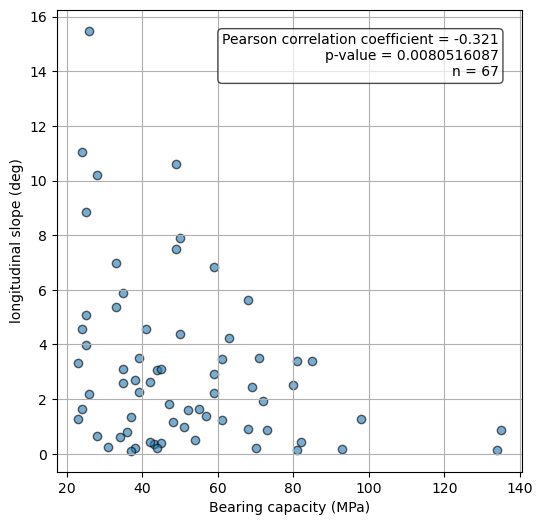

Pearson correlation coefficient: -0.321, p-value: 0.0080516087


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

bcs = np.array(bcs)
slopes = np.array(slopes)

plt.figure(figsize=(6,6))
plt.scatter(bcs, slopes, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(bcs, slopes)
n = len(slopes)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("Bearing capacity (MPa)")
plt.ylabel("longitudinal slope (deg)")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(bcs, slopes)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")

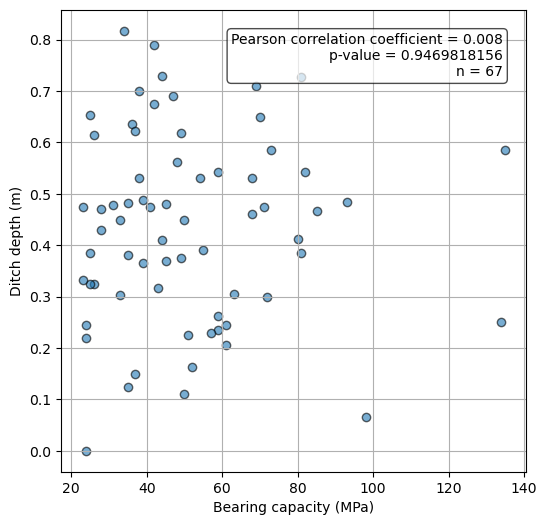

Pearson correlation coefficient: 0.008, p-value: 0.9469818156


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

bcs = np.array(bcs)
ditch_depths = np.array(ditch_depths)

plt.figure(figsize=(6,6))
plt.scatter(bcs, ditch_depths, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(bcs, ditch_depths)
n = len(ditch_depths)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("Bearing capacity (MPa)")
plt.ylabel("Ditch depth (m)")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(bcs, ditch_depths)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")

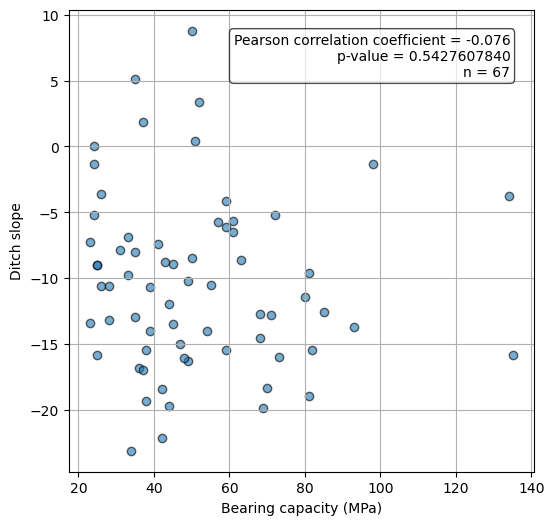

Pearson correlation coefficient: -0.076, p-value: 0.5427607840


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

bcs = np.array(bcs)
ditch_slopes = np.array(ditch_slopes)

plt.figure(figsize=(6,6))
plt.scatter(bcs, ditch_slopes, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(bcs, ditch_slopes)
n = len(ditch_slopes)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("Bearing capacity (MPa)")
plt.ylabel("Ditch slope")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(bcs, ditch_slopes)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")

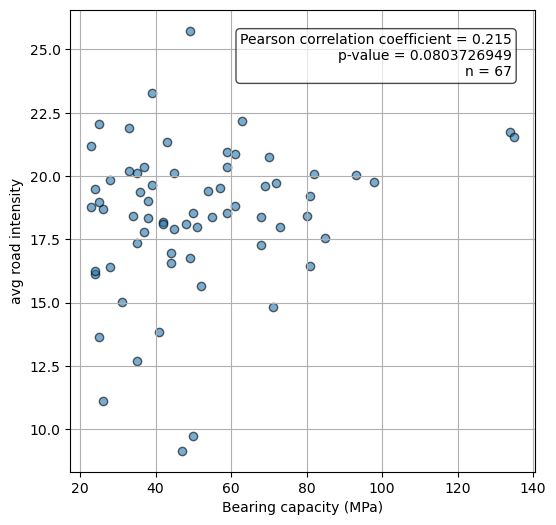

Pearson correlation coefficient: 0.215, p-value: 0.0803726949


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

bcs = np.array(bcs)
avg_road_intensities = np.array(avg_road_intensities)

plt.figure(figsize=(6,6))
plt.scatter(bcs, avg_road_intensities, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(bcs, avg_road_intensities)
n = len(avg_road_intensities)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("Bearing capacity (MPa)")
plt.ylabel("avg road intensity")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(bcs, avg_road_intensities)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")

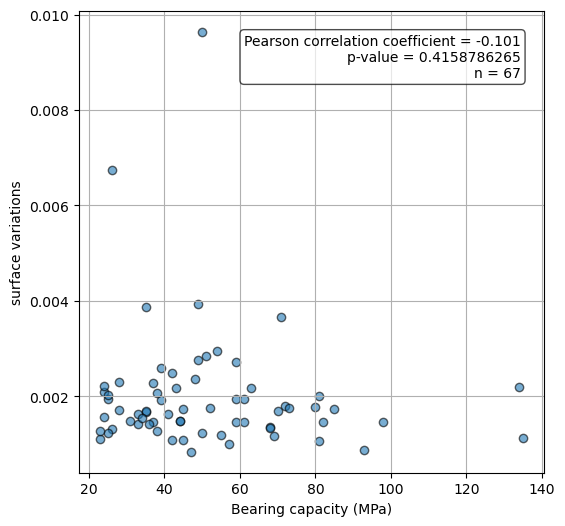

Pearson correlation coefficient: -0.101, p-value: 0.4158786265


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

bcs = np.array(bcs)
surface_variations = np.array(surface_variations)

plt.figure(figsize=(6,6))
plt.scatter(bcs, surface_variations, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(bcs, surface_variations)
n = len(surface_variations)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("Bearing capacity (MPa)")
plt.ylabel("surface variations")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(bcs, surface_variations)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")

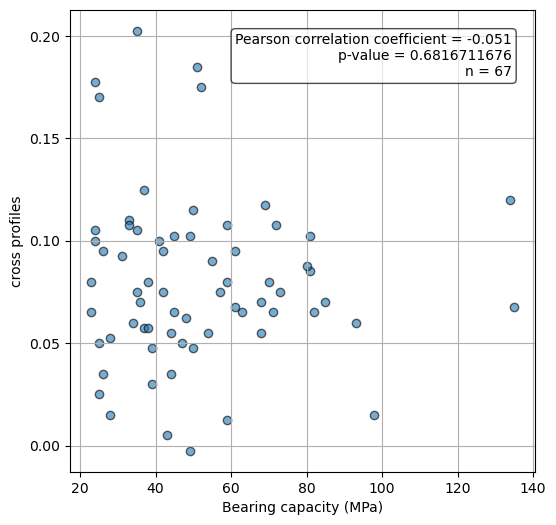

Pearson correlation coefficient: -0.051, p-value: 0.6816711676


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

bcs = np.array(bcs)
cross_profiles = np.array(cross_profiles)

plt.figure(figsize=(6,6))
plt.scatter(bcs, cross_profiles, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(bcs, cross_profiles)
n = len(cross_profiles)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("Bearing capacity (MPa)")
plt.ylabel("cross profiles")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(bcs, cross_profiles)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")